# Sandwich shop
We want to investigate if adding an extra crew member during rush hour is worth our trouble.

#### Some relevant information:
* The arrival time between clients $\left(T\right)$ is a stochastic variable following an exponential distribution with parameter $\lambda(t)$, where $\lambda$ also depends on the time of day. From historical data we know the following about the mean time between client arrivals:
    * from 00:00 until 08:00: shop is closed
    * from 08:00 until 11:00: 25 minutes
    * from 11:00 until 14:00: 1 minutes
    * from 14:00 until 17:00: 10 minutes
    * from 17:00 until 19:00: 2 minutes
    * from 19:00 until 20:00: 5 minutes
    * from 20:00 until 24:00: shop is closed
    
    **Remark: in reality you would execute a measurements campaign and verify if the experimental distribution actually follows an exponential distribution (by means of a Kolmogorov–Smirnov test)**
        
* If an employee is available the client places an order (we could also incorporate a decision time). This implies that we need the shop to have a limited `::Resource` i.e. the employees. 

    If no one is available, the client waits for his turn, but has a limited amount of patience. When this runs out, the clients leaves the shop (and should cancel his request for the employee `Resource`). Patience for the different clients is defined as a random variable $\sim\mathcal{U}(5,10)$. 
    * `Resource.level` is the current amount of resources in use
    * `Resource.capacity` is the total amount of resources
    * `Resource.put_queue` are the scheduled processes for the resource and can be used for queue length
* Once the order is placed, the preperation time is also a random variable (possibly depending on the type of sandwich).

#### Topics:

1. We need to log the activities in our shop:
    1. Queue build-up $\rightarrow$ logging of queue required
    2. Waiting times $\rightarrow$ logging of waiting times required

#### Some food for thought:
* What if we considered clients with a memory? I.e. if they do not get served within their patience range, they go away and spread they word (which in its turn influences future arrival rates).
* Is the extra person worth it from an economic point of view?
* Could you also include orders that are place by phone before a specific time (also requiring the staff's attention?
* to get the authentic shop feeling, we could use the `Dates` package and use actual date and hour for the plots

### Dependencies, Logging setup and supporting functions:
* plots will be made using the [Plots](http://docs.juliaplots.org/latest/) package with the [GR](http://docs.juliaplots.org/latest/examples/gr/) backend (see also: [GR](https://gr-framework.org/julia.html)). 
* The [Distributions](https://juliastats.github.io/Distributions.jl/stable/) package will be used for distributions and randomness. 
* The [Logging](https://docs.julialang.org/en/v1/stdlib/Logging/index.html) module will be used for efficient debugging and testing during development.
* The [StatsBase](http://juliastats.github.io/StatsBase.jl/latest/index.html) package provides basic support for statistics. We will use it for experimental PDF and CDF in particular.
* The [HypothesisTests]() package contains hypothesis tests that can use to test if our data follows a specific distribution (e.g. normality with a KS-test) or to determine confidence intervals on data (e.g. 95% CI for mean waiting time).



In [1]:
# Dependencies
using Dates              # for actual time & date
using Distributions      # for distributions
using HypothesisTests    # for more statistical analysis
using Logging            # for debugging
using LinearAlgebra      # to normalize histograms
using Plots              # for pretty figures
using Plots.PlotMeasures # to use mm/px as units for plot margins if desired
using StatsBase          # for nicer histograms (cf. solution)
using SimJulia

# plotting backend
Plots.gr()

# Logging
mylogger = Logging.SimpleLogger(stdout,LogLevel(-10000))
Logging.global_logger(mylogger)
Logging.disable_logging(LogLevel(-4500));

# supporting function
"""Return mean time between arrival in minutes"""
function arrivalrate(t::DateTime)
    if (hour(t) >= 8) & (hour(t) < 11)
        return 25
    elseif (hour(t) >= 11) & (hour(t) < 14)
        return 1 #1.5
    elseif (hour(t) >= 14) & (hour(t) < 17)
        return 10
    elseif (hour(t) >= 17) & (hour(t) < 19)
        return 2
    elseif (hour(t) >= 19) & (hour(t) < 20)
        return 5
    end
end;
                
# adding some constants for the menu
const menulist = ["sandwich, cold","sandwich, hot","pasta","soup"]
const menuprob = Distributions.Categorical([0.6,0.2,0.1,0.1])
const preptimes = Dict( menulist[1]=>Distributions.Uniform(60,90), 
                        menulist[2]=>Distributions.Uniform(60,120), 
                        menulist[3]=>Distributions.Uniform(60,90),
                        menulist[4]=>Distributions.Uniform(30,45))

Dict{String,Uniform{Float64}} with 4 entries:
  "soup"           => Uniform{Float64}(a=30.0, b=45.0)
  "sandwich, cold" => Uniform{Float64}(a=60.0, b=90.0)
  "sandwich, hot"  => Uniform{Float64}(a=60.0, b=120.0)
  "pasta"          => Uniform{Float64}(a=60.0, b=90.0)

In [16]:
keuze = menulist[rand(menuprob)]
preptime = rand(preptimes[keuze])
println("ik kies voor $(keuze) en dat duurt $(preptime) seconden")

ik kies voor sandwich, hot en dat duurt 115.33412929006582 seconden


### Arrival process and initial demonstration:

In [17]:
# to be added with the problem description
@resumable function arrivals(sim::Simulation)
    topen = 8    # opening time
    tclose = 20  # closing time
    while true
        if hour(nowDatetime(sim)) < topen         # check if we're open (mornings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim)),topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "waiting to open (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        if hour(nowDatetime(sim)) >= tclose         # check if we're open (again, evenenings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim))+1,topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "Closing, waiting to reopen (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        
        @logmsg LogLevel(-5000) "it is now: $(nowDatetime(sim))"
        
        # Actual arrivals
        try   # avoid blocking because arrivalrate returns 'None' for times outside of [8-20]
            twait = Second(round(rand(Distributions.Exponential(arrivalrate(nowDatetime(sim))))*60))
            @yield timeout(sim,twait)
            
        catch
           @yield timeout(sim,Second(1)) 
        end 
    end
end


arrivals (generic function with 1 method)

In [24]:
# Simple illustration
Logging.disable_logging(LogLevel(-5000))
sim = Simulation(round(now(),Day) + Hour(1))
@process arrivals(sim)
run(sim,round(now(),Day) + Hour(22))

┌ LogLevel(-4500): Warning: it is now: 2018-10-30T01:00:00
└ @ Main In[17]:7
┌ LogLevel(-4500): waiting to open (for: 25200000 milliseconds)
└ @ Main In[17]:9
┌ LogLevel(-4500): Warning: it is now: 2018-10-30T20:02:50
└ @ Main In[17]:14
┌ LogLevel(-4500): Closing, waiting to reopen (for: 43030000 milliseconds)
└ @ Main In[17]:16


### Solution
to do...

In [23]:
# Dependencies
using Dates              # for actual time & date
using Distributions      # for distributions
using HypothesisTests    # for more statistical analysis
using Logging            # for debugging
using LinearAlgebra      # to normalize histograms
using Plots              # for pretty figures
using Plots.PlotMeasures # to use mm/px as units for plot margins if desired
using StatsBase          # for nicer histograms (cf. solution)
using SimJulia

# plotting backend
Plots.gr()

# Logging
mylogger = Logging.SimpleLogger(stdout,LogLevel(-10000))
Logging.global_logger(mylogger)
Logging.disable_logging(LogLevel(-4500));

# supporting function
"""Return mean time between arrival in minutes"""
function arrivalrate(t::DateTime)
    if (hour(t) >= 8) & (hour(t) < 11)
        return 25
    elseif (hour(t) >= 11) & (hour(t) < 14)
        return 1 #1.5
    elseif (hour(t) >= 14) & (hour(t) < 17)
        return 10
    elseif (hour(t) >= 17) & (hour(t) < 19)
        return 2
    elseif (hour(t) >= 19) & (hour(t) < 20)
        return 5
    end
end;
                
# adding some constants for the menu
const menulist = ["sandwich, cold","sandwich, hot","pasta","soup"]
const menuprob = Distributions.Categorical([0.6,0.2,0.1,0.1])
const preptimes = Dict( menulist[1]=>Distributions.Uniform(60,90), 
                        menulist[2]=>Distributions.Uniform(60,120), 
                        menulist[3]=>Distributions.Uniform(60,90),
                        menulist[4]=>Distributions.Uniform(30,45))

# own types:
struct Shop
    crew::Resource
    queue::Array # wachtrijlengtes + DTG
    waittimes::Array # wachttijd + DGT
    clients::Dict
    reneg::Array # aantal verlaters + DTG
    function Shop(sim::Simulation,ncrew::Int=1)
        crew = Resource(sim,ncrew)
        queue = [(nowDatetime(sim),0)]
        waittimes = []
        reneg = []
        clients = Dict()
        new(crew,queue,waittimes,clients,reneg)
    end
end

mutable struct Client
    id::Int
    patience::Real
    proc::Process
    timesrenegged::Int
    function Client(sim::Simulation,s::Shop)
        c = new()
        c.id = length(s.clients) + 1
        c.patience = round(rand(Distributions.Uniform(5*60,10*60)))
        c.timesrenegged = 0
        c.proc = @process clientbehavior(sim,s,c)
        return c
    end
end


In [66]:

# to be added with the problem description
@resumable function arrivals(sim::Simulation,shop::Shop)
    topen = 8    # opening time
    tclose = 20  # closing time
    while true
        if hour(nowDatetime(sim)) < topen         # check if we're open (mornings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = floor(nowDatetime(sim),Day) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "waiting to open (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        if hour(nowDatetime(sim)) >= tclose         # check if we're open (again, evenenings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = floor(nowDatetime(sim),Day) + Day(1) + Hour(topen) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "Closing, waiting to reopen (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        
        @logmsg LogLevel(-5000) "it is now: $(nowDatetime(sim))"
        
        # Actual arrivals
        try   # avoid blocking because arrivalrate returns 'None' for times outside of [8-20]
            twait = Second(round(rand(Distributions.Exponential(arrivalrate(nowDatetime(sim))))*60))
            @yield timeout(sim,twait)
            c = Client(sim,shop)
            shop.clients[c.id] = c
            # queue length 
            push!(shop.queue,(nowDatetime(sim),length(shop.crew.put_queue)))
        catch
           @yield timeout(sim,Second(1)) 
        end 
    end
end

arrivals (generic function with 1 method)

In [68]:
@resumable function clientbehavior(sim::Simulation,s::Shop,c::Client)
    @logmsg LogLevel(-1500)  "I'm client N° $(c.id) with $(c.patience) patience [s], I reneged $(c.timesrenegged) times"
    @logmsg LogLevel(-1500) "I arrive on time $(nowDatetime(sim))"
    
    # kiezen:
    @yield timeout(sim, Second(round(rand(Distributions.Uniform(0,30)))))
    keuze = menulist[rand(menuprob)]
    preptime = rand(preptimes[keuze])
    # begin wachten
    tin = nowDatetime(sim)
    # personeel vragen:
    req = SimJulia.request(s.crew)
    # kijken wie eerst
    res = @yield req | timeout(sim, Second(c.patience))
    if res[req].state == SimJulia.processed
        # actual wait time
        twait = nowDatetime(sim) - tin
        # wait time stockeren
        push!(s.waittimes,(nowDatetime(sim),twait))
        # bestellen!
        @logmsg LogLevel(-500) "Client N° $(c.id) orders a $(keuze) on time $(nowDatetime(sim)) "
        # preptime
        @yield timeout(sim,Second(round(preptime)))
        release(s.crew)
    else
        # leaving the queue
        @logmsg LogLevel(-500) "Client N° $(c.id) is out of patience! :-( on time $(nowDatetime(sim)) "
        c.timesrenegged += 1
        push!(s.reneg,nowDatetime(sim))
        SimJulia.cancel(s.crew,req)
    end
end

clientbehavior (generic function with 1 method)

In [78]:
# A single simulation
Logging.disable_logging(LogLevel(0))
sim = Simulation(floor(now(),Day)+Hour(8))
shop = Shop(sim,1)
@process arrivals(sim,shop)
run(sim,floor(now(),Day)+Hour(21))

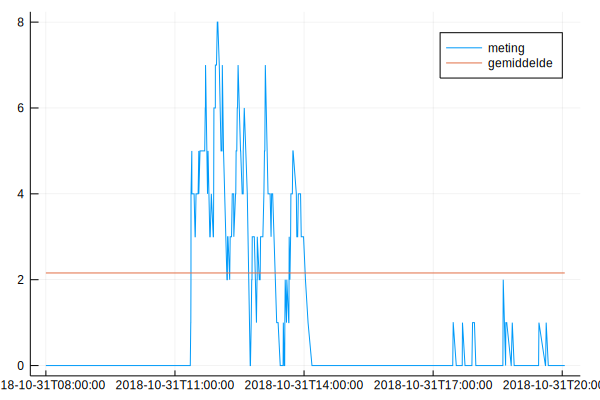

In [79]:
# ruwe prent
tijd = [x[1] for x in shop.queue]
rijlengte = [x[2] for x in shop.queue]
plot(tijd,rijlengte,label="meting")
plot!([tijd[1],tijd[end]],[1,1].*mean(rijlengte),label="gemiddelde")

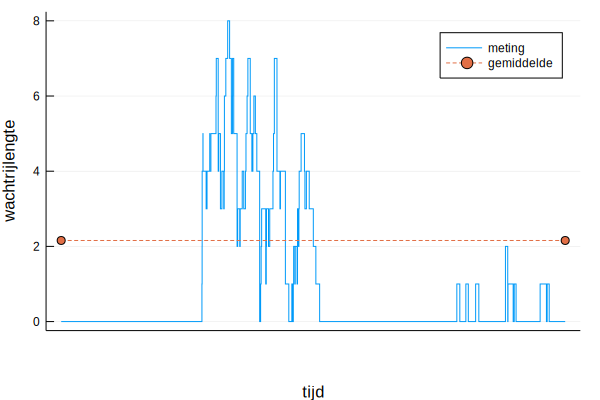

In [110]:
# zelfde prent met make-up:
tijd = [x[1] for x in shop.queue]
rijlengte = [x[2] for x in shop.queue]

plot(tijd,rijlengte,label="meting", line=(:steppost)) # other type of line,
plot!([tijd[1],tijd[end]],[1,1].*mean(rijlengte),label="gemiddelde",linestyle=:dash,marker=:circle) # anothe linestyle for mean + markers
plot!(xlabel="tijd",ylabel="wachtrijlengte")

# waardes voor de assen:
xtick = floor(now(),Day) + Hour(8) : Minute(30) : floor(now(),Day) + Hour(22) # DateTime range
xtickval = Dates.value.(xtick) # numerical value (in seconds) for x-axis
xticklabel = Dates.format.(xtick,"e HH:MM") # actual labels we will use (Dates format cf. documentation)
xticks!(xtickval,xticklabel)

plot!(xrotation=90) # rotate x-axis label

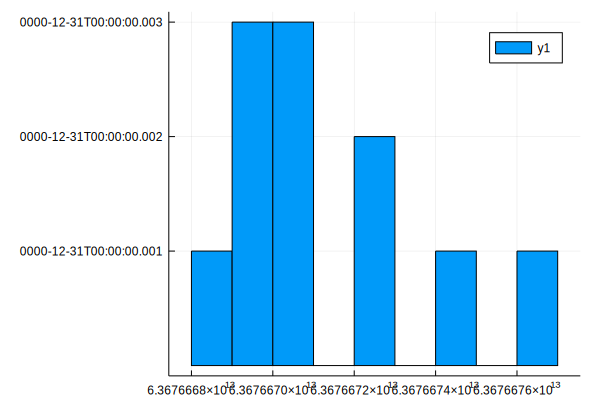

In [112]:
# histogram van renegtimes (lelijke optie):
Plots.histogram(shop.reneg,nbins=12)

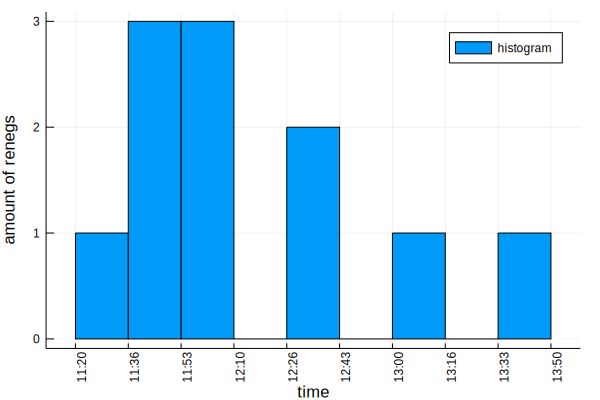

In [113]:
# zelfde histogram, maar via StatsBase en met makeup
his = StatsBase.fit(Histogram,Dates.value.(shop.reneg),nbins=12, closed=:right)
# Grenzen van de staafjes bepalen
binborders = his.edges[1]
# Grenzen omvormen naar leesbare waarden
binlabels = Dates.format.(Dates.epochms2datetime.(binborders),"HH:MM")
plot(his,label="histogram",xlabel="time",ylabel="amount of renegs")
xticks!(binborders,binlabels)
plot!(xrotation=90)


### To do:
Run several simulations and store data + do some analysis